In [1]:
import os
os.chdir("..")
import sys
sys.path.append(os.getcwd())
print(os.getcwd())

/home/spotparking/SpotBackend


In [31]:
import time

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jeffutils.analytics import set_np_pd_display_params
set_np_pd_display_params(np, pd)

from IPython.display import clear_output

from jeffutils.utils import reimport
reimport("""
from modules.graphics.display import extract_first_frame, extract_last_frame, extract_all_frames
""", globals())
from modules.graphics.display import extract_first_frame, extract_last_frame, extract_all_frames
from modules.helpers.data_dir_manager import datapath

# set paths to the video and record

In [10]:
video_path = datapath("zoning_joe/rec-2024-12-10-22-13-20_small.mp4")
record_path = datapath("zoning_joe/rec-2024-12-10-22-13-20_small.csv")
spotID = "004-0016"
track_id = 172
record = pd.read_csv(record_path)
rel_track_record = record[record["track_id"] == track_id]
frames = extract_all_frames(video_path)

# setup the points for the driving region and parking region

In [35]:
parking_region_pix = np.array([
    [545, 129],
    [674, 156],
    [774, 291],
    [610, 263],
])
driving_region_pix = np.array([
    [357, 60],
    [522, 85],
    [666, 385],
    [401, 385],
])

# display the driving and parking regions

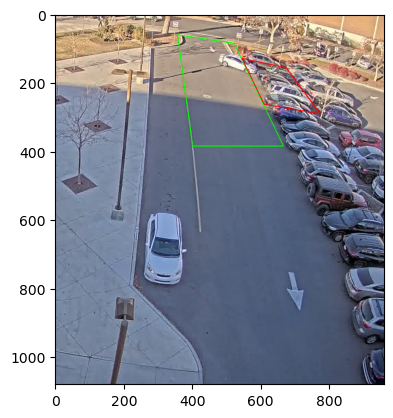

In [34]:
frame_number = 60
frame = frames[frame_number].copy()
cv2.imwrite(datapath("misc/joe_region_image.png"), frame)

# draw the driving region
cv2.polylines(frame, [driving_region_pix], isClosed=True, color=(0, 255, 0), thickness=2)
# draw the parking region
cv2.polylines(frame, [parking_region_pix], isClosed=True, color=(0, 0, 255), thickness=2)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()


# display the video with the bbox a different color based on in driving region or parking region

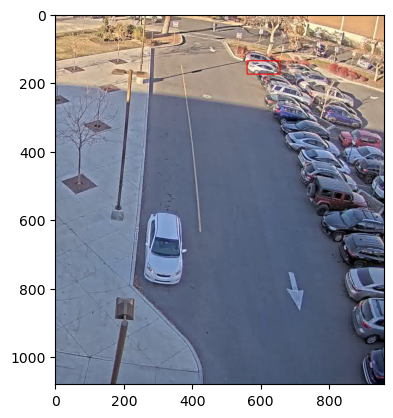

In [36]:
def is_in_zone(x:int, y:int, zone:np.ndarray) -> bool:
    return cv2.pointPolygonTest(zone, (int(x), int(y)), measureDist=False) >= 0

def is_in_zone_vec(centers:np.ndarray, zone:np.ndarray) -> np.ndarray:
    return np.array([
        is_in_zone(x, y, zone)
        for x, y in centers
    ]).astype(bool)

rel_track_record['in_driving_region'] = is_in_zone_vec(rel_track_record[['cx', 'cy']].values.astype(int), driving_region_pix)
rel_track_record['in_parking_region'] = is_in_zone_vec(rel_track_record[['cx', 'cy']].values.astype(int), parking_region_pix)

for i, (tl_x, tl_y, w, h, in_driv_reg, in_park_reg) in enumerate(rel_track_record[['tl_x', 'tl_y', 'w', 'h', 'in_driving_region', 'in_parking_region']].values):
    if any([np.isnan(k) for k in [tl_x, tl_y, w, h]]):
        continue
    
    disp_frame = frames[i].copy()
    if in_driv_reg:
        cv2.rectangle(disp_frame, (int(tl_x), int(tl_y)), (int(tl_x + w), int(tl_y + h)), (0, 255, 0), 2)
    if in_park_reg:
        cv2.rectangle(disp_frame, (int(tl_x), int(tl_y)), (int(tl_x + w), int(tl_y + h)), (0, 0, 255), 2)
    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(disp_frame, cv2.COLOR_BGR2RGB))
    time.sleep(0.1)
    plt.show()
    